<h1>Step 0. Importing necessary libraries</h1>

In [162]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [163]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Convolution2D, Flatten, Dense
from tensorflow.python.keras.optimizers import adam_v2

<h1>Step 1. Gathering the data information</h1>

In [164]:
def removePath(path):
    return path.split('/')[-1]

def collectData(path):
    cols = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names=cols)
    print('Total Images Imported: ', data.shape[0])
    data['Center'] = data['Center'].apply(removePath)
    data['Left'] = data['Left'].apply(removePath)
    data['Right'] = data['Right'].apply(removePath)
    print(data.head())
    return data

In [165]:
data = collectData('data')

Total Images Imported:  8036
                               Center                              Left  \
0  center_2016_12_01_13_30_48_287.jpg  left_2016_12_01_13_30_48_287.jpg   
1  center_2016_12_01_13_30_48_404.jpg  left_2016_12_01_13_30_48_404.jpg   
2  center_2016_12_01_13_31_12_937.jpg  left_2016_12_01_13_31_12_937.jpg   
3  center_2016_12_01_13_31_13_037.jpg  left_2016_12_01_13_31_13_037.jpg   
4  center_2016_12_01_13_31_13_177.jpg  left_2016_12_01_13_31_13_177.jpg   

                               Right  Steering  Throttle  Brake      Speed  
0  right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0  22.148290  
1  right_2016_12_01_13_30_48_404.jpg       0.0       0.0    0.0  21.879630  
2  right_2016_12_01_13_31_12_937.jpg       0.0       0.0    0.0   1.453011  
3  right_2016_12_01_13_31_13_037.jpg       0.0       0.0    0.0   1.438419  
4  right_2016_12_01_13_31_13_177.jpg       0.0       0.0    0.0   1.418236  


<h1>Step 2. Visualizing and Balancing the data<h1>

In [166]:
def balanceData(data, visualize=True):
    nBins = 31
    maxSamplesPerBin = 1000
    hist, bins = np.histogram(data['Steering'], nBins)
    if visualize:
        center = (bins[:-1] + bins[1:])*0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((-1, 1), (maxSamplesPerBin, maxSamplesPerBin))
        plt.show()

    removeIndexList = []
    for j in range(nBins):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j+1]:
                binDataList.append(i)

        binDataList = shuffle(binDataList)
        binDataList = binDataList[maxSamplesPerBin:]
        removeIndexList.extend(binDataList)

    print('Removed Images: ', len(removeIndexList))
    data.drop(data.index[removeIndexList], inplace=True)
    print('Remaining Images: ', len(data))

    if visualize:
        hist, _ = np.histogram(data['Steering'], nBins)
        plt.bar(center, hist, width=0.06)
        plt.plot((-1, 1), (maxSamplesPerBin,  maxSamplesPerBin))
        plt.show()

    return data

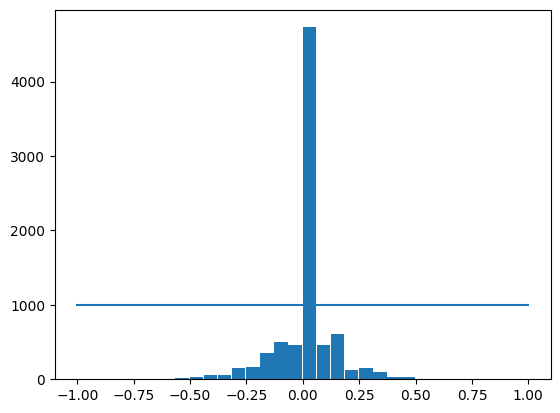

Removed Images:  3730
Remaining Images:  4306


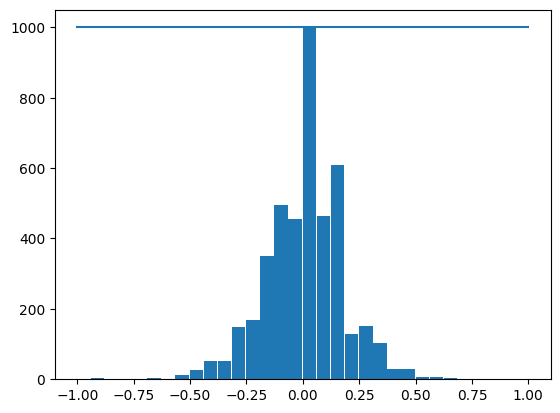

In [167]:
data = balanceData(data, visualize=True)

<h1>Step 3. Preparing for pre processing</h1>

In [168]:
def loadData(path, data):
    imagesPath = []
    steering = []

    for i in range(len(data)):
        indexedData = data.iloc[i]
        imagesPath.append(os.path.join(path, 'IMG', indexedData[0]))
        steering.append(float(indexedData[3]))

    imagesPath = np.asarray(imagesPath)
    steering = np.asarray(steering)

    return imagesPath, steering

In [169]:
imagesPath, steerings = loadData('data', data)
print(imagesPath[0], steerings[0])

data/IMG/center_2016_12_01_13_31_13_177.jpg 0.0


<h1>Step 4. Splitting into Test and Validation Set

In [170]:
x_train, x_validation, y_train, y_validation = train_test_split(imagesPath, steerings, test_size=0.2, random_state=5)
print('Total Training Images: ', len(x_train))
print('Total Validation Images: ', len(x_validation))

Total Training Images:  3444
Total Validation Images:  862


<h1>Step 5. Image Augmentation</h1>

In [171]:
def augmentImage(imgPath, steering):
    img = mpimg.imread(imgPath)

    # PAN
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
        img = pan.augment_image(img)

    # Zoom
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)

    # Brightness
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.4, 1.2))
        img = brightness.augment_image(img)

    # Flip
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering

    return img, steering

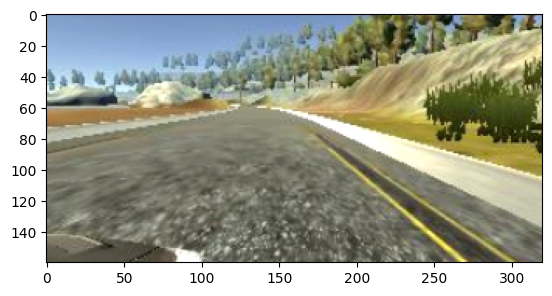

In [172]:
imgRe, st = augmentImage('test.jpg', 0)
plt.imshow(imgRe)
plt.show()

<h1>Step 6. Data pre processing</h1>

In [173]:
def preprocessing(img):
    img = img[60:135,:,:] # Cropping image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # Colour Space from RGB to YUV
    img = cv2.GaussianBlur(img, (3,3), 0) # Gaussian Blur
    img = cv2.resize(img, (200, 66)) # Resizing image
    img = img/255 # Normalizing image
    return img

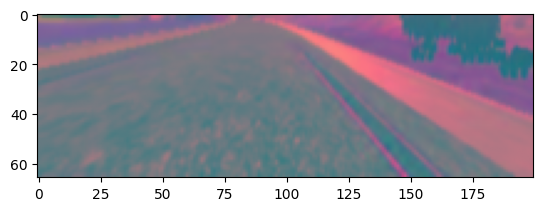

In [174]:
imgRe = preprocessing(mpimg.imread('test.jpg'))
plt.imshow(imgRe)
plt.show()

<h1>Step 7. Batch Generation</h1>

In [175]:
def batchGeneration(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath)-1)

            if trainFlag:
                img , steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]

            img = preprocessing(img)
            imgBatch.append(img)
            steeringBatch.append(steering)

        yield (np.asarray(imgBatch), np.asarray(steeringBatch))

<h1>Step 8. Nvidia CNN Model</h1>

In [176]:
def createModel():
    model = Sequential()

    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))

    model.add(Flatten())

    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))

    model.compile(adam_v2.Adam(learning_rate=0.0001), loss='mse')
    return model

In [177]:
model = createModel()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)              

<h1>Step 9. Model Training</h1>

In [178]:
history = model.fit(batchGeneration(x_train, y_train, 100, 1),
          steps_per_epoch=300,
          epochs=10,
          validation_data=batchGeneration(x_validation, y_validation, 100, 0),
          validation_steps=200)

Epoch 1/10
300/300 [==============================] - 175s 583ms/step - loss: 0.0280 - val_loss: 0.0202
Epoch 2/10
300/300 [==============================] - 170s 569ms/step - loss: 0.0225 - val_loss: 0.0178
Epoch 3/10
300/300 [==============================] - 165s 552ms/step - loss: 0.0211 - val_loss: 0.0186
Epoch 4/10
300/300 [==============================] - 175s 586ms/step - loss: 0.0200 - val_loss: 0.0165
Epoch 5/10
300/300 [==============================] - 195s 651ms/step - loss: 0.0197 - val_loss: 0.0182
Epoch 6/10
300/300 [==============================] - 173s 577ms/step - loss: 0.0181 - val_loss: 0.0160
Epoch 7/10
300/300 [==============================] - 169s 564ms/step - loss: 0.0177 - val_loss: 0.0164
Epoch 8/10
300/300 [==============================] - 177s 593ms/step - loss: 0.0176 - val_loss: 0.0158
Epoch 9/10
300/300 [==============================] - 179s 598ms/step - loss: 0.0170 - val_loss: 0.0155
Epoch 10/10
300/300 [==============================] - 175s 584m

In [179]:
model.save('model.h5')

<h1>Step 10. Plotting Model</h1>

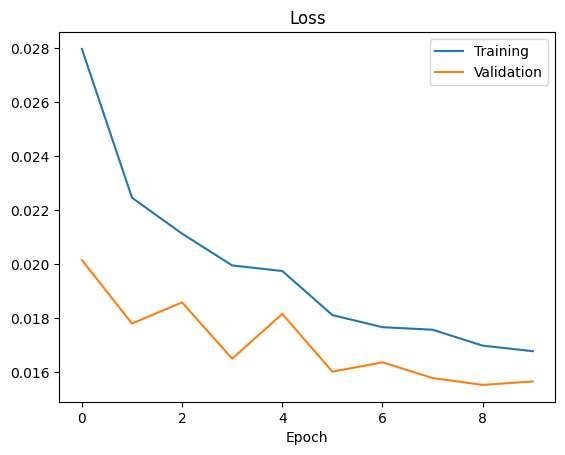

In [180]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()